### Целевая функция

Будем оптимизировать функцию лог-регрессии
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i (Ax)_i))
$$
, где $x \in \mathbb{R}^d$, $L= \text{max}_i \| A_i \|^2$, $L_0 = 0$, $L_1 = \text{max}_i \| A_i \|$ $(\| A_i \| >> 1)$

### Данные 
1) Случайные данные на l2 шаре при увеличении размерности. Данные НЕ скореллированные, зашумленность невысокая
2) Случайные данные на симплексе при увеличении размерности. Данные НЕ скореллированные, зашумленность невысокая
3) Случайные данные на l-\infty шаре при увеличении размерности. Данные НЕ скореллированные, зашумленность невысокая

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости (FW-L0_L1_shortest)
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости, параметры настраиваются по очереди, сначала L_0, потом L_1 (FW-L0_L1_toggle)
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости, но настройка в соответствии с долей конкретного параметра (FW-L0_L1_flexible). Параметры так же настраиваются по очереди.

### Цель эксперимента

1) Я хочу понять дает ли прирост в скорости сходимости более гибкая схема адаптации:
```Python
if linesearch and k != 0:
	L0 /= ls_ratio + L0 / a_k # чем выше доля конкретного параметра, тем сильнее он регулируется
	L1 /= ls_ratio + (L1 * g_norm) / a_k
...
L0 *= ls_ratio - L0 / a_k
L1 *= ls_ratio - (L1 * g_norm) / a_k
```

Т.е. чем больше доля параметра $L_0$ или $L_1$ в сумму $L = L_0 + L_1 \| \nabla f(x) \|$, тем сильнее/меньше он увеличивается или уменьшается.

2) Нужно понять действительно ли эта гибкость дала такой прирост или просто увеличение/уменьшение `ls_ratio`? Для этого увеличить `ls_ratio` В ОБОИХ алгоритмах и смотреть на результат.
3) Дает ли прирост в скорости тактика, когда мы регулируем на одной итерации сначала параметр L_0, а затем параметр L_1?

In [37]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [ ]:
import numpy as np
import jax
import matplotlib.pyplot as plt
import time

import accbpg

random_seed = 456

In [ ]:
def FW_alg_L0_L1_shortest_step(
    f, h, L0, L1, x0, maxitrs, gamma, lmo, epsilon=1e-14,
    linesearch=True, flex_regime=False, toggle_regime=False, 
    ls_ratio=2, verbose=True, verbskip=1
):
    r"""
    Frank-Wolfe algorithm for (L0, L1)-smooth functions with shortest-step rule.

    This routine minimizes a composite objective of the form

        F(x) = f(x) + h.extra_Psi(x),

    where `f` is (L0, L1)-smooth. The step-size (this is quite similar to the classic shortest-step rule):

        alpha_k = min( [ -<∇f(x), d> / (a_k * D(s, x) * e) ]^(1 / (γ - 1)), 1 ),

    where `d = s - x`, `s` is returned by the Linear Minimization Oracle (LMO),
    `D(s, x)` is a divergence measure provided by `h`, `a_k = L0 + L1 * ||∇f(x)||`,
    and `γ > 1` is a curvature parameter.

    Parameters
    ----------
    f : object
        Target function.
    h : object with a convex penalty term.
    L0 : float
        Initial zero-order smoothness parameter (must be nonnegative).
    L1 : float
        Initial first-order smoothness parameter (must be nonnegative).
    x0 : ndarray
        Initial feasible point.
    maxitrs : int
        Maximum number of iterations.
    gamma : float
        Exponent in the shortest-step rule, must satisfy `γ > 1`.
    lmo : callable
        Linear Minimization Oracle (LMO).
    epsilon : float, optional (default=1e-14)
        Stopping tolerance on successive objective values.
    linesearch : bool, optional (default=True)
        Whether to use line search or not.
    ls_ratio : float, optional (default=2)
        Factor by which `(L0, L1)` are scaled during line search. Must be >= 1.
    verbose : bool, optional (default=True)
        If True, prints progress information.
    verbskip : int, optional (default=1)
        Frequency (in iterations) of verbose output.

    Returns
    -------
    x : ndarray
        Final iterate.
    F : ndarray
        Array of objective values across iterations.
    Ls : ndarray
        Sequence of smoothness constants `a_k = L0 + L1 * ||∇f(x)||`.
    T : ndarray
        Cumulative runtime (in seconds) at each iteration.
    """
    if ls_ratio < 1:
        raise ValueError("ls_ratio must be >= 1")
    if L0 < 0 or L1 < 0:
        raise ValueError("Initial L must be positive")
    if epsilon <= 0:
        raise ValueError("epsilon must be positive")

    if verbose:
        print("\nFW (L0,L1)-smooth algorithm with shortest-step rule")
        print("     k        F(x)          a_k           L0            L1        alpha        time")


    start_time = time.time()
    F, Ls, T = [], [], []
    delta = 1e-8

    x = np.copy(x0)
    toggle = 0

    for k in range(maxitrs):
        fx, g = f.func_grad(x)
        F.append(fx + h.extra_Psi(x))
        T.append(time.time() - start_time)
        s_k = lmo(g)
        d_k = s_k - x
        div = h.divergence(s_k, x)
        if div == 0:
            div = delta

        grad_d_prod = np.dot(g.ravel(), d_k.ravel())
        if 0 < grad_d_prod <= delta:
            grad_d_prod = 0
        if grad_d_prod > 0:
            raise ValueError("⟨∇f(x), d⟩ must be nonpositive (LMO issue).")

        g_norm = np.linalg.norm(g)
        a_k = L0 + L1 * g_norm
        
        if linesearch and flex_regime:
            L0 /= ls_ratio + L0 / a_k
            L1 /= ls_ratio + (L1 * g_norm) / a_k
        
        if linesearch:
            L0 = L0 / ls_ratio
            L1 = L1 / ls_ratio

        while True:
            a_k = L0 + L1 * g_norm
            # attention: in case of euklidian divergence, we have div = 0.5 ||s-x||^2
            # so we already have 2 power in the denominator
            alpha_k = min((-grad_d_prod / (a_k * div * np.e)) ** (1 / (gamma - 1)), 1) 
            x1 = x + alpha_k * d_k

            if not linesearch:
                break
                
            if f.func_grad(x1, flag=0) <= fx + alpha_k * grad_d_prod + alpha_k ** gamma * (a_k / 2) * np.e * div:
                break

            if flex_regime:
                if toggle == 0:
                    L0 *= ls_ratio - L0 / a_k
                    toggle = 1
                else:
                    L1 *= ls_ratio - (L1 * g_norm) / a_k
                    toggle = 0
            elif toggle_regime:
                if toggle == 0:
                    L0 *= ls_ratio
                    toggle = 1
                else:
                    L1 *= ls_ratio
                    toggle = 0
            else:
                L0 *= ls_ratio
                L1 *= ls_ratio

        x = x1

        Ls.append(a_k)
        if verbose and k % verbskip == 0:
            print(f"{k:6d}   {F[k]:10.3e}   {Ls[k]:10.3e}   {L0:10.3e}   {L1:10.3e}   {alpha_k:10.3e}   {T[k]:6.1f}")

        if k > 0 and abs(F[k] - F[k - 1]) < epsilon:
            break

    return x, np.array(F), np.array(Ls), np.array(T)

## $L_2$-шар, увеличение числа векторов

Running for n_samples=200, n_features=200

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    2.158e+01    1.077e+01    1.077e+01    1.368e-03      0.1
    50    1.280e-05    7.872e-05    7.872e-05    7.872e-05    9.092e-03      0.1

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    7.992e+00    3.992e+00    3.990e+00    3.692e-03      0.0
    50    1.150e-06    2.880e-05    1.640e-05    4.182e+00    3.131e-03      0.1

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    2.158e+01    1.077e+01    1.077e+01    1.368e-03      0.0
    50    6.787e-06    3.578e-05    3.578e-05    1.626e-05    1.088e-02      0.1
Running for n_samples=2000, n_features=200

FW (L0,L1)-smooth

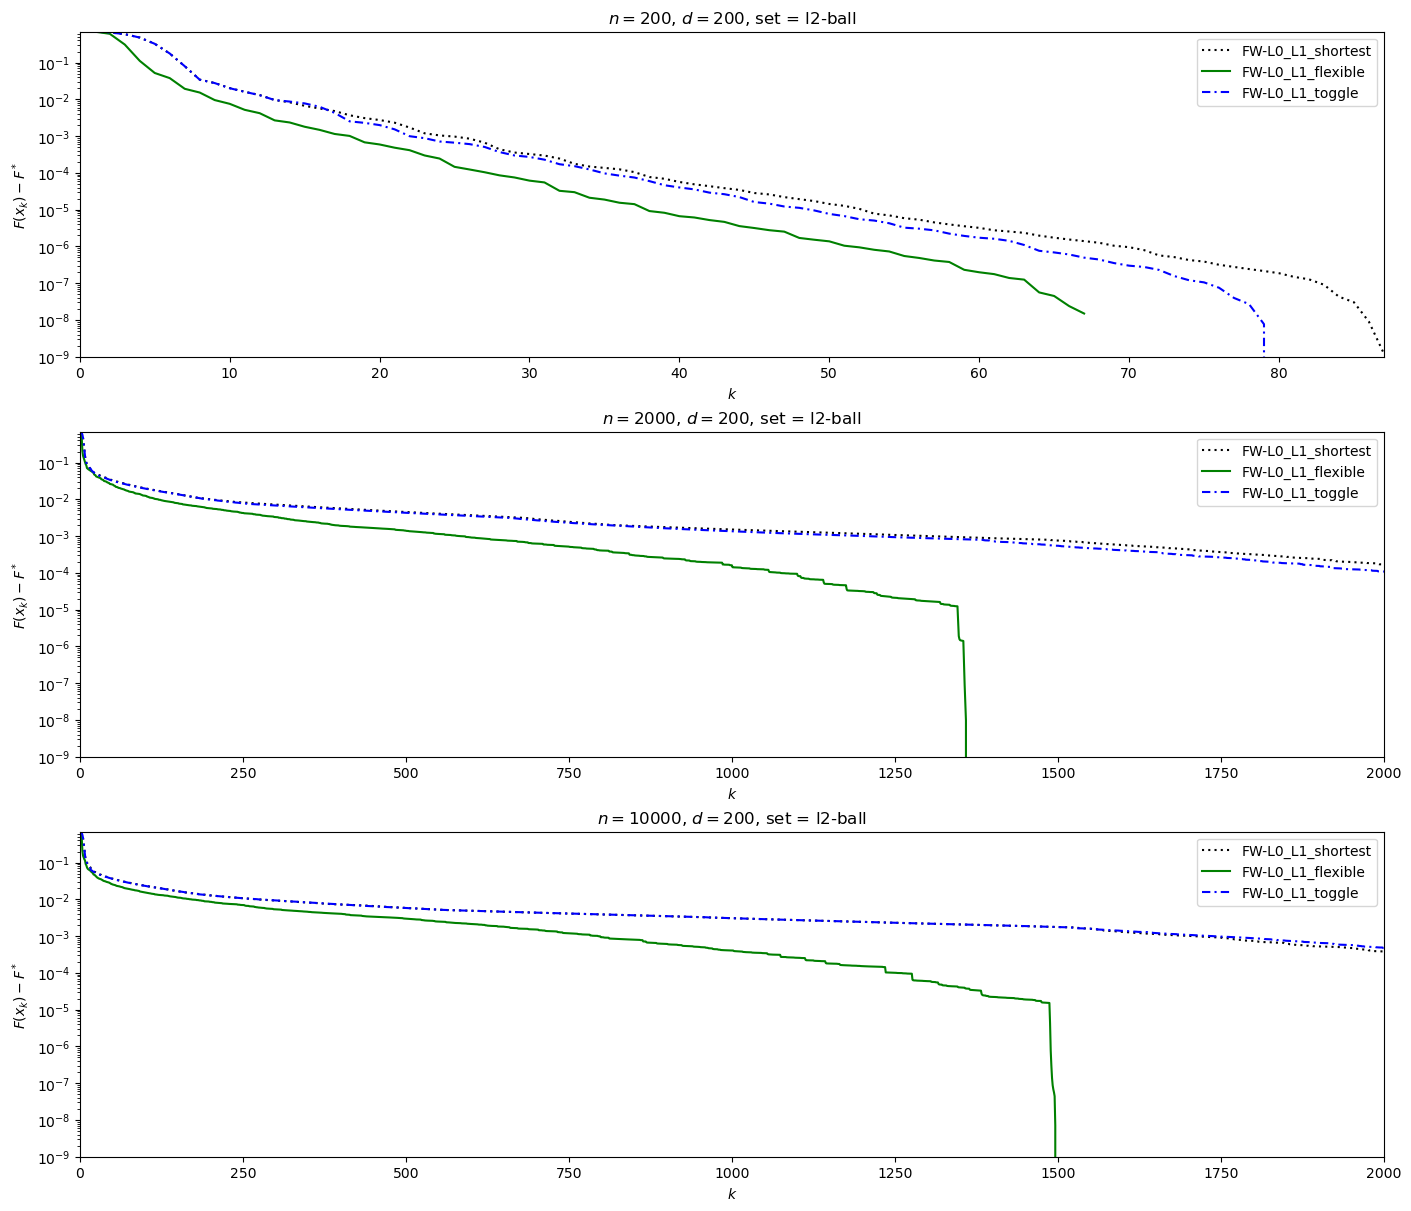

In [40]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = int(max_iters / 40)
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_shortest", r"FW-L0_L1_flexible", r"FW-L0_L1_toggle"]

configs = [
    (200, 200),
    (2000, 200),
    (10000, 200),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.02,
                                                     col_scale=2,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_shortest_step, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )
    _, F_l0l1_shortest_step_flexible, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=True
    )
    _, F_l0l1_shortest_step_toggle, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=False, toggle_regime=True
    )

    y_min = min(np.min(F_l0l1_shortest_step), np.min(F_l0l1_shortest_step_flexible), np.min(F_l0l1_shortest_step_toggle))
    y_max = max(np.max(F_l0l1_shortest_step), np.max(F_l0l1_shortest_step_flexible), np.max(F_l0l1_shortest_step_toggle))

    max_executed_iters = max(len(F_l0l1_shortest_step), len(F_l0l1_shortest_step_flexible), len(F_l0l1_shortest_step_toggle))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_shortest_step, F_l0l1_shortest_step_flexible, F_l0l1_shortest_step_toggle],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## $L_2$-шар, увеличение размерности

Running for n_samples=200, n_features=200

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    2.158e+01    1.077e+01    1.077e+01    1.368e-03      0.1
    50    1.280e-05    7.872e-05    7.872e-05    7.872e-05    9.092e-03      0.2

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    7.992e+00    3.992e+00    3.990e+00    3.692e-03      0.0
    50    1.150e-06    2.880e-05    1.640e-05    4.182e+00    3.131e-03      0.1

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    2.158e+01    1.077e+01    1.077e+01    1.368e-03      0.0
    50    6.787e-06    3.578e-05    3.578e-05    1.626e-05    1.088e-02      0.1
Running for n_samples=200, n_features=2000

FW (L0,L1)-smooth

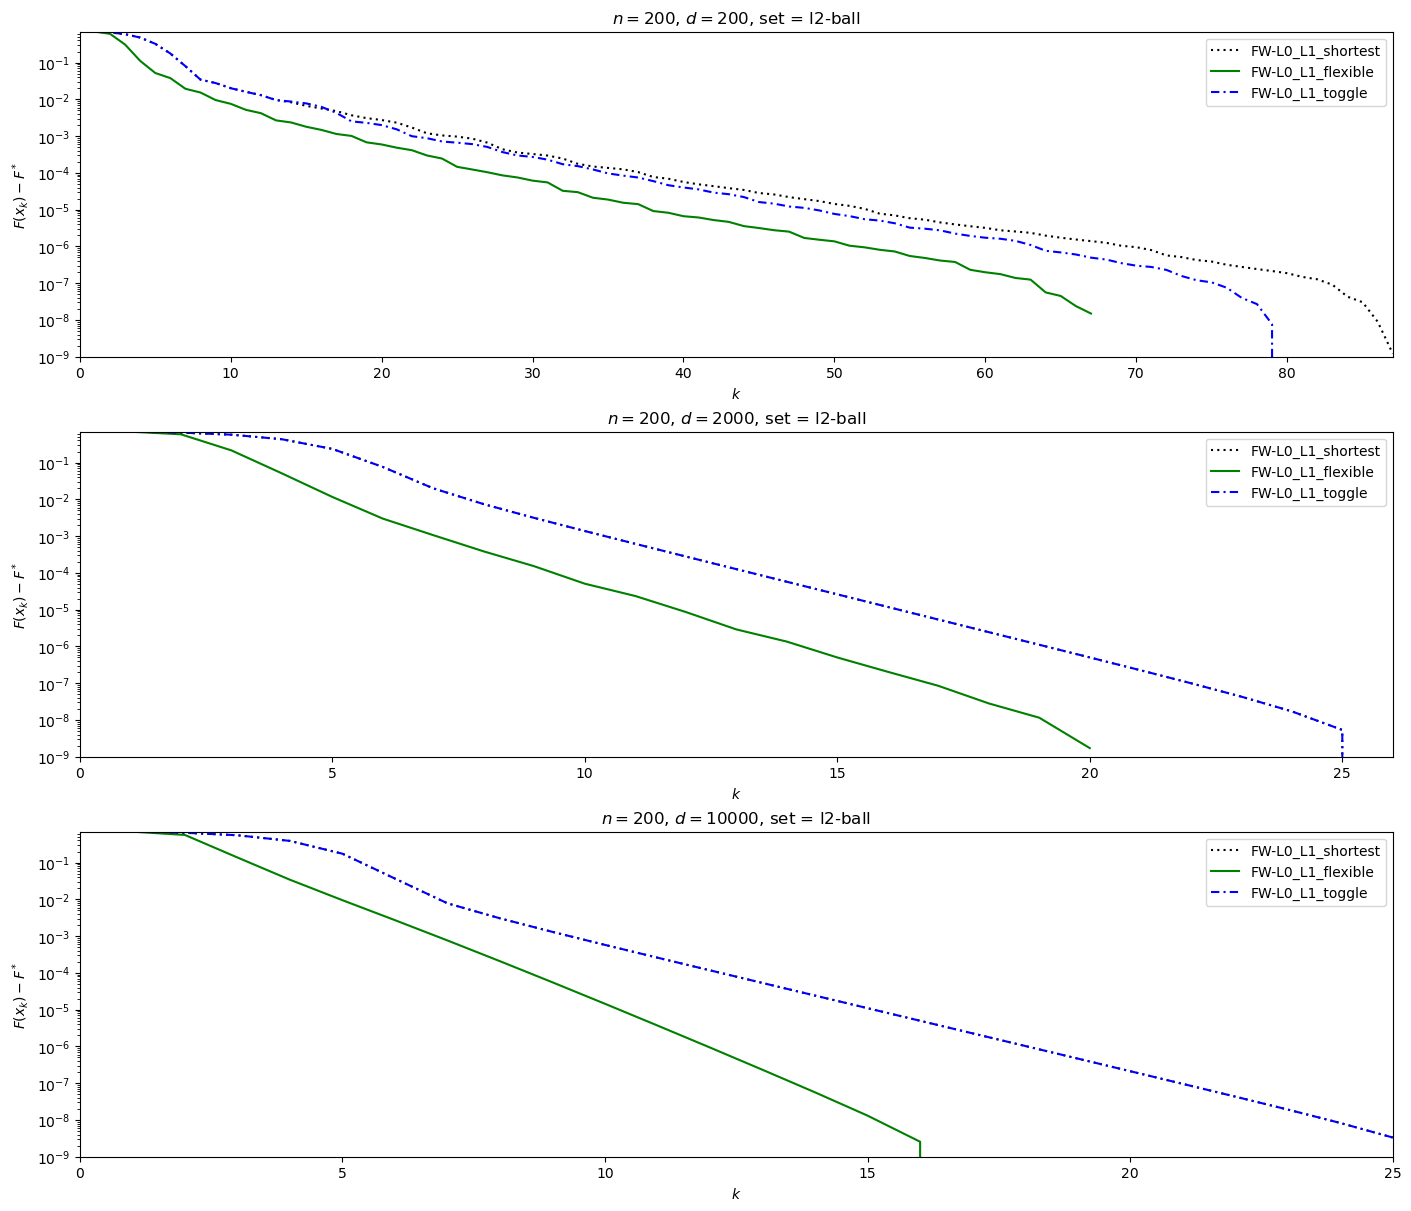

In [41]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = int(max_iters / 40)
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_shortest", r"FW-L0_L1_flexible", r"FW-L0_L1_toggle"]

configs = [
    (200, 200),
    (200, 2000),
    (200, 10000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.02,
                                                     col_scale=2,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_shortest_step, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )
    _, F_l0l1_shortest_step_flexible, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=True
    )
    _, F_l0l1_shortest_step_toggle, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=False, toggle_regime=True
    )

    y_min = min(np.min(F_l0l1_shortest_step), np.min(F_l0l1_shortest_step_flexible), np.min(F_l0l1_shortest_step_toggle))
    y_max = max(np.max(F_l0l1_shortest_step), np.max(F_l0l1_shortest_step_flexible), np.max(F_l0l1_shortest_step_toggle))

    max_executed_iters = max(len(F_l0l1_shortest_step), len(F_l0l1_shortest_step_flexible))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_shortest_step, F_l0l1_shortest_step_flexible, F_l0l1_shortest_step_toggle],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Симплекс, увеличение размерности

Running for n_samples=200, n_features=2000

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    1.048e+02    3.131e+01    3.131e+01    3.113e-03      0.1
   200    4.418e-01    7.474e-01    2.762e-01    2.762e-01    3.580e-03      0.4
   400    4.410e-01    7.468e-01    2.762e-01    2.762e-01    3.120e-03      0.6
   600    4.407e-01    7.466e-01    2.762e-01    2.762e-01    1.217e-03      0.9
   800    4.405e-01    7.465e-01    2.762e-01    2.762e-01    1.573e-03      1.1
  1000    4.404e-01    7.464e-01    2.762e-01    2.762e-01    7.337e-04      1.3
  1200    4.404e-01    7.464e-01    2.762e-01    2.762e-01    1.052e-03      1.6
  1400    4.403e-01    7.463e-01    2.762e-01    2.762e-01    5.253e-04      1.8
  1600    4.403e-01    7.463e-01    2.762e-01    2.762e-01    7.907e-04      2.0
  1800    4.403e-01    7.463e-01    2.762e-01    2.762e-01    4.091e-04      2.3

FW (L0,L1

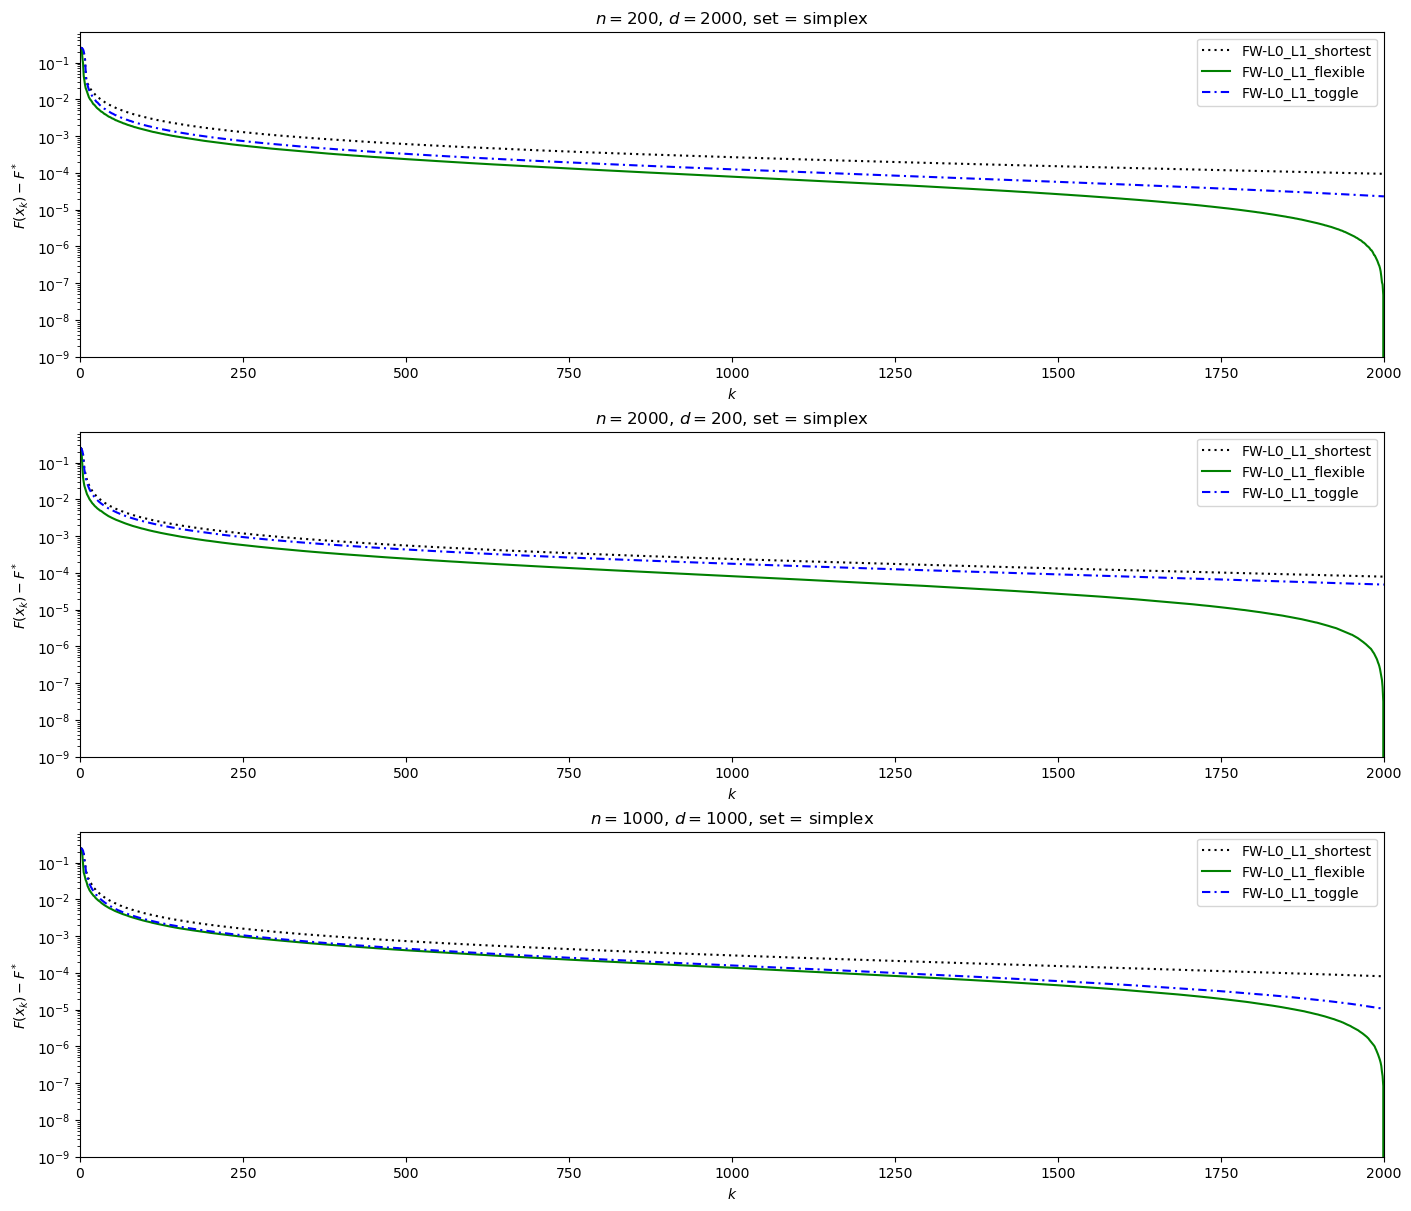

In [42]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 1

labels = [r"FW-L0_L1_shortest", r"FW-L0_L1_flexible", r"FW-L0_L1_toggle"]

configs = [
    (200, 2000),
    (2000, 200),
    (1000, 1000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="simplex",
                                                     k_sparse=5,
                                                     rho=0.02,
                                                     col_scale=2,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_simplex(ball_constrnt_radius)
    lmo_name = "simplex"

    _, F_l0l1_shortest_step, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )
    _, F_l0l1_shortest_step_flexible, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=True
    )
    _, F_l0l1_shortest_step_toggle, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=False, toggle_regime=True
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_shortest_step), np.min(F_l0l1_shortest_step_flexible), np.min(F_l0l1_shortest_step_toggle))
    y_max = max(np.max(F_l0l1_shortest_step), np.max(F_l0l1_shortest_step_flexible), np.max(F_l0l1_shortest_step_toggle))

    max_executed_iters = max(len(F_l0l1_shortest_step), len(F_l0l1_shortest_step_flexible), len(F_l0l1_shortest_step_toggle))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_shortest_step, F_l0l1_shortest_step_flexible, F_l0l1_shortest_step_toggle],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## $L_{\infty}$ шар

Running for n_samples=200, n_features=2000

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    5.633e+01    2.113e+01    2.113e+01    1.566e-05      0.1

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    2.067e+01    8.205e+00    7.480e+00    4.269e-05      0.0

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    5.633e+01    2.113e+01    2.113e+01    1.566e-05      0.0
Running for n_samples=2000, n_features=200

FW (L0,L1)-smooth algorithm with shortest-step rule
     k        F(x)          a_k           L0            L1        alpha        time
     0    6.931e-01    1.073e+01    7.547e+00    7.547e+00    7.603e-05      0.1
   200    7.293e-03    6.257e-03    6.251e

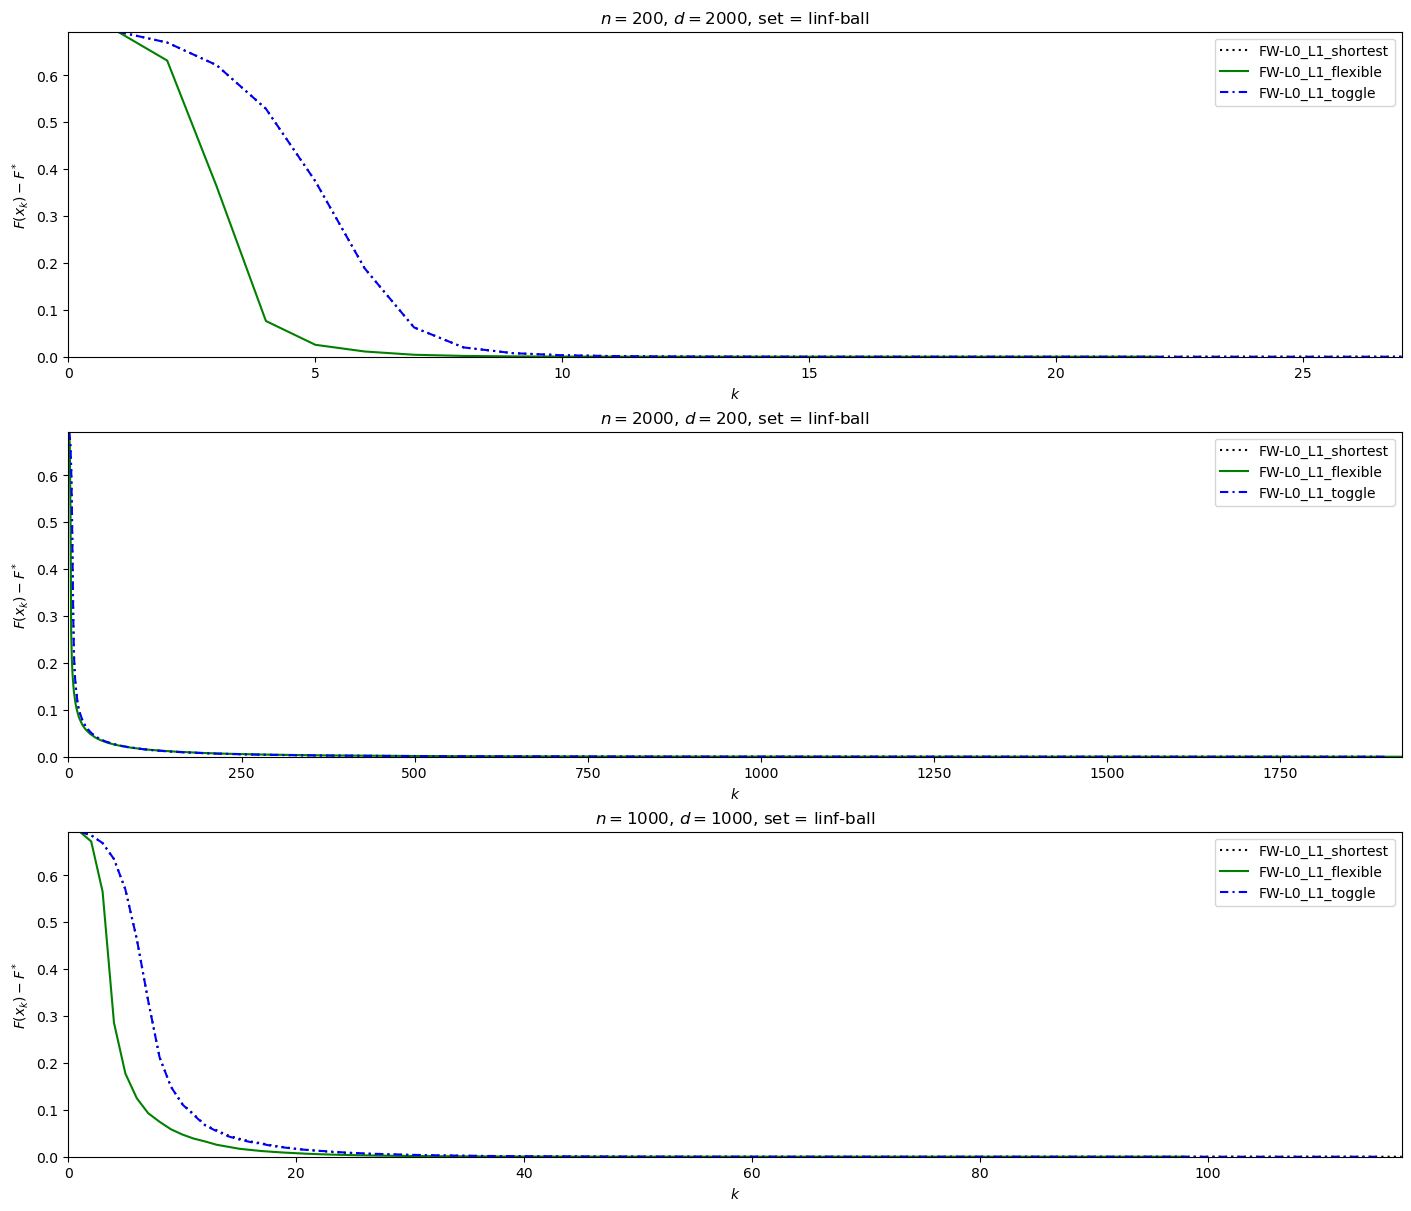

In [43]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_shortest", r"FW-L0_L1_flexible", r"FW-L0_L1_toggle"]

configs = [
    (200, 2000),
    (2000, 200),
    (1000, 1000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="linf",
                                                     rho=0.001,
                                                     col_scale=1.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_linf_ball(ball_constrnt_radius)
    lmo_name = "linf-ball"

    _, F_l0l1_shortest_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )
    _, F_l0l1_shortest_step_flexible, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=True
    )
    _, F_l0l1_shortest_step_toggle, _, _ = FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip, flex_regime=False, toggle_regime=True
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_shortest_step), np.min(F_l0l1_shortest_step_flexible), np.min(F_l0l1_shortest_step_toggle))
    y_max = max(np.max(F_l0l1_shortest_step), np.max(F_l0l1_shortest_step_flexible), np.max(F_l0l1_shortest_step_toggle))

    max_executed_iters = max(len(F_l0l1_shortest_step), len(F_l0l1_shortest_step_flexible))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_shortest_step, F_l0l1_shortest_step_flexible, F_l0l1_shortest_step_toggle],
        labels,
        xlim=[0, max_executed_iters], ylim=[0, y_max], plotdiff=True, yscale="linear",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Выводы

Эксперименты однозначно показали, что дополнительная "добавка" к адаптации в FW-L0_L1_flexible дает ускорение для абсолютно всех случаев, этот алгоритм победил во всех экспериментах. Пчму так происходит? Такая настройка более тонка, она не увеличивает параметр черезчур резко, а делает это более гибко и мягко. 

Более того, следует обратить внимание на то, что по очереди переключать параметры дает дополнительный прирост к скорости. Пчму? Птмчто общая сумма $a_k = L_0 + L_1 \| \nabla f(x_k) \|$ не взлетают слишком быстро, а растет более постепенно и остановится раньше, чем более агрессивная настройка, когда мы переключаем сразу 2 параметра.